# **Predict Calorie Expenditure**

In [3]:
import pandas as pd
import numpy as np
import os

In [11]:

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")

In [9]:
test.head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [10]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample shape:", sample.shape)

Train shape: (750000, 9)
Test shape: (250000, 8)
Sample shape: (250000, 2)


In [12]:
train.info()
train.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


In [13]:
train.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Matplotlib is building the font cache; this may take a moment.


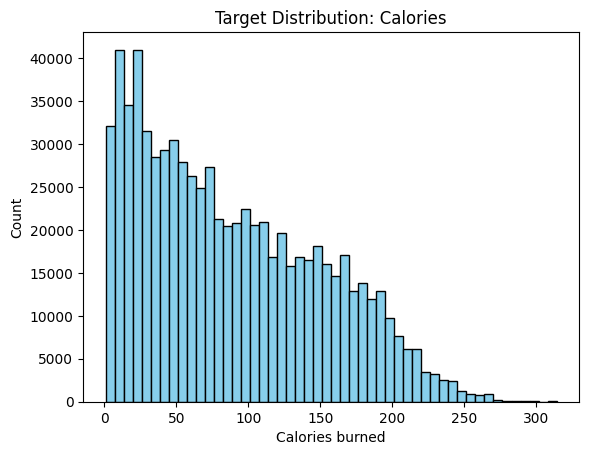

In [15]:
import matplotlib.pyplot as plt

plt.hist(train["Calories"], bins=50, color="skyblue", edgecolor="black")
plt.title("Target Distribution: Calories")
plt.xlabel("Calories burned")
plt.ylabel("Count")
plt.show()

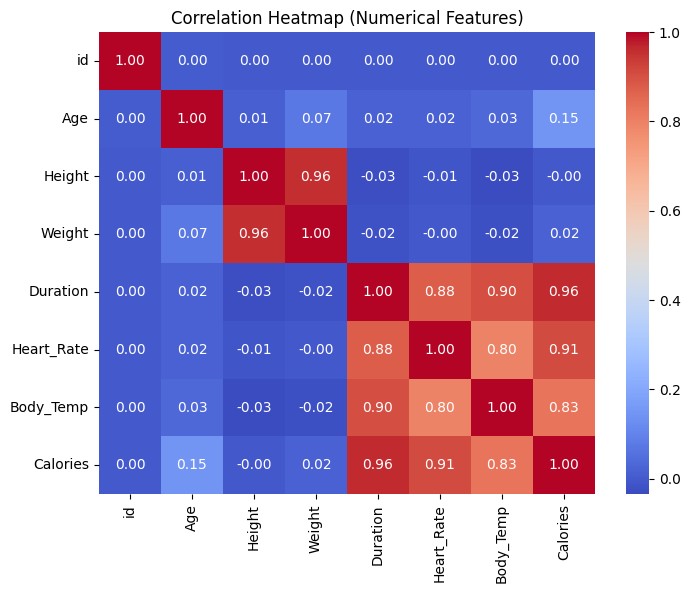

In [17]:
import seaborn as sns

num_cols = train.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

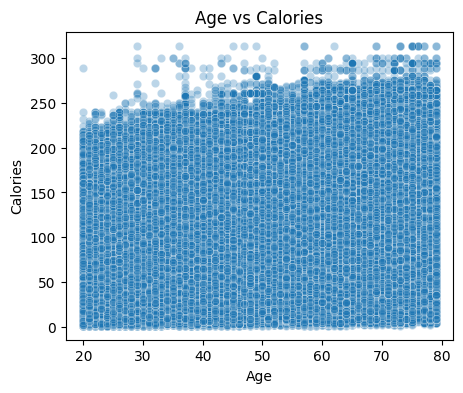

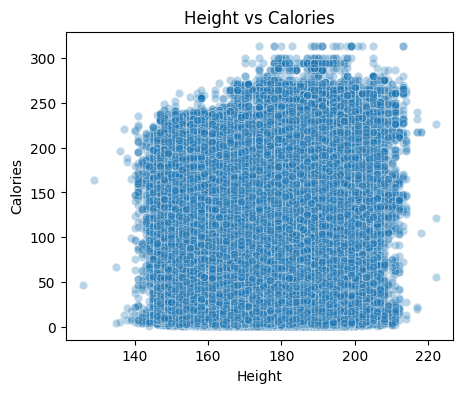

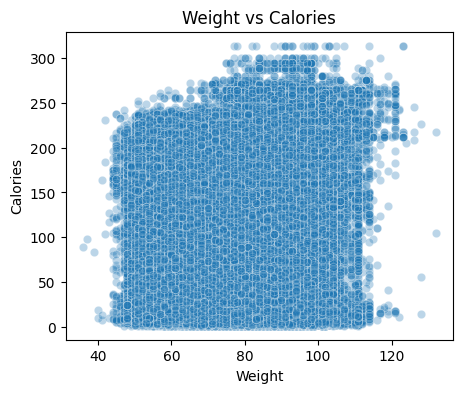

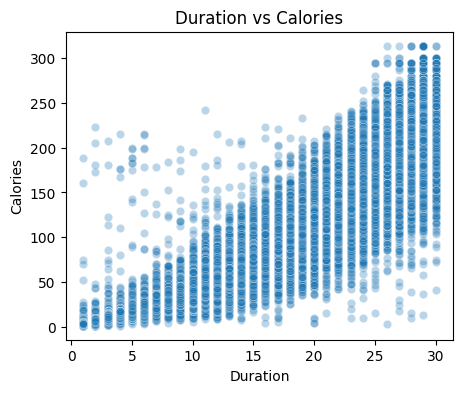

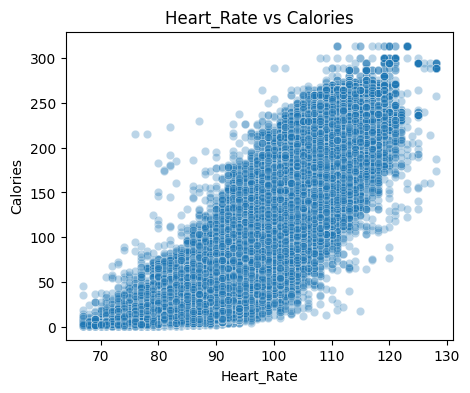

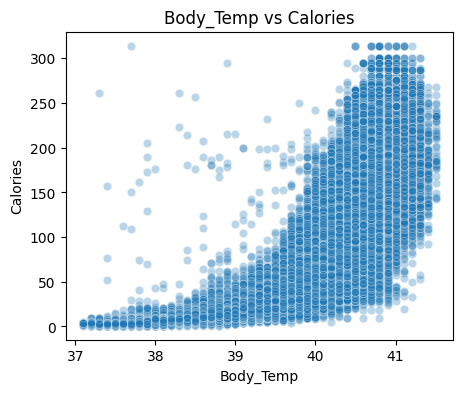

In [18]:
for col in ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=train, x=col, y="Calories", alpha=0.3)
    plt.title(f"{col} vs Calories")
    plt.show()

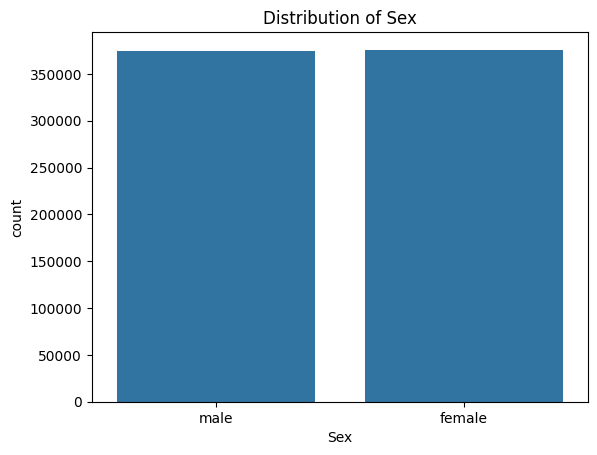

In [19]:
sns.countplot(data=train, x="Sex")
plt.title("Distribution of Sex")
plt.show()